# Run Different Optimization Scenarios in the TSA 24 ws3 model

Optionally, uninstall the ws3 package and replace it with a pointer to this local clone of the GitHub repository code (useful if you want ot tweak the source code for whatever reason).

## Set up modelling environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ws3
ws3.__path__

['/media/data/project/yyan/tmp/ws3/examples/ws3']

In [3]:
# install_ws3 = True
# install_ws3_localeditable = None
# if install_ws3:
#     if install_ws3_localeditable: # clobber ws3 installation with local editable copy
#         %pip uninstall -y ws3
#         %pip install -e ..
#     else: # install dev_libcbm branch from ws3 GitHub repo
#         %pip install -U git+https://github.com/gparadis/ws3@dev_libcbm
#     import ws3
#     ws3.__path__

In [4]:
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and run `ForestModel` instance

In [5]:
%pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
Start = time.time()

In [7]:
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [8]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [9]:
from util import compile_scenario, plot_scenario

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total net Emission (tons)'}>],
       dtype=object))

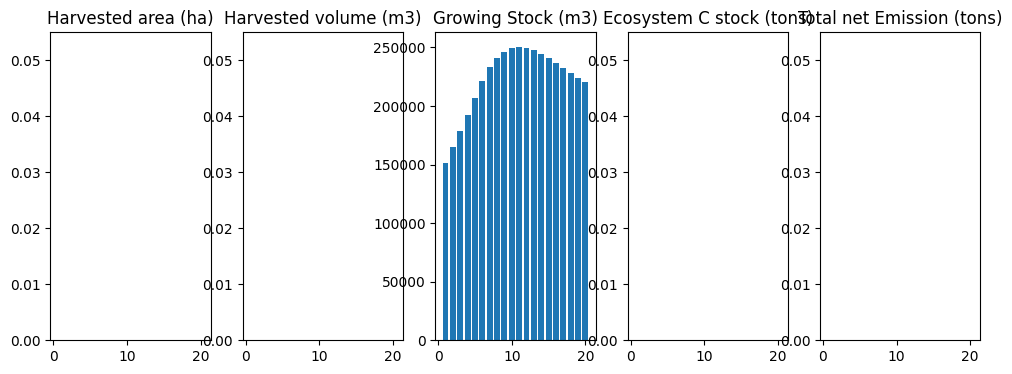

In [10]:
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [11]:
import libcbm
from util import run_cbm, cbm_report, plugin_c_curves, compare_ws3_cbm

Prepare CBM input files

In [12]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [13]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [15]:
sit_classifiers = pd.read_csv('data/libcbm_model_files/sit_classifiers.csv')
sit_disturbance_types = pd.read_csv('data/libcbm_model_files/sit_disturbance_types.csv')
sit_age_classes = pd.read_csv('data/libcbm_model_files/sit_age_classes.csv')
sit_inventory = pd.read_csv('data/libcbm_model_files/sit_inventory.csv')
sit_yield = pd.read_csv('data/libcbm_model_files/sit_yield.csv')
sit_events = pd.read_csv('data/libcbm_model_files/sit_events.csv')
# sit_events = fm._cbm_sit_events()
sit_transitions = pd.read_csv('data/libcbm_model_files/sit_transitions.csv')

In [16]:
sit_tables = {'sit_classifiers': sit_classifiers,
              'sit_disturbance_types': sit_disturbance_types,
              'sit_age_classes': sit_age_classes,
              'sit_inventory': sit_inventory,
              'sit_yield': sit_yield,
              'sit_events': sit_events,
              'sit_transitions': sit_transitions}

In [17]:
# self = fm
# sit_tables = {'sit_classifiers':self._cbm_sit_classifiers(),
#               'sit_disturbance_types':self._cbm_sit_disturbance_types(),
#               'sit_age_classes':self._cbm_sit_age_classes(),
#               'sit_inventory':self._cbm_sit_inventory(softwood_volume_yname='swdvol', 
#                                                       hardwood_volume_yname='hwdvol'),
#               'sit_yield':self._cbm_sit_yield(softwood_volume_yname='swdvol', 
#                                               hardwood_volume_yname='hwdvol', n_yield_vals=100),
#               'sit_events':self._cbm_sit_events(),
#               'sit_transitions':self._cbm_sit_transitions()}

In [18]:
# sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
#                                        hardwood_volume_yname='hwdvol', 
#                                        admin_boundary='British Columbia', 
#                                        eco_boundary='Montane Cordillera',
#                                        disturbance_type_mapping=disturbance_type_mapping)

In [19]:
n_steps = fm.horizon * fm.period_length
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

Define carbon pools

In [20]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Define carbon fluxes

In [21]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

In [22]:
pools = ecosystem_pools
fluxes = all_fluxes

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['all_fluxes']

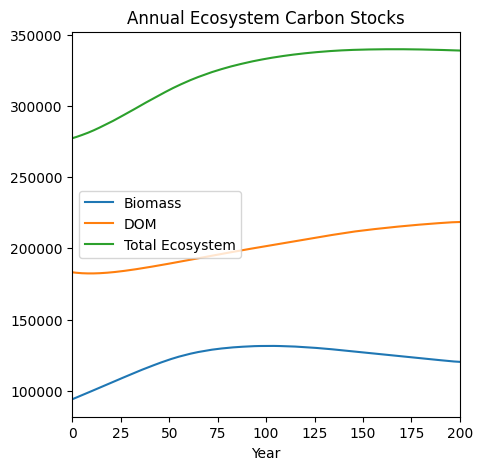

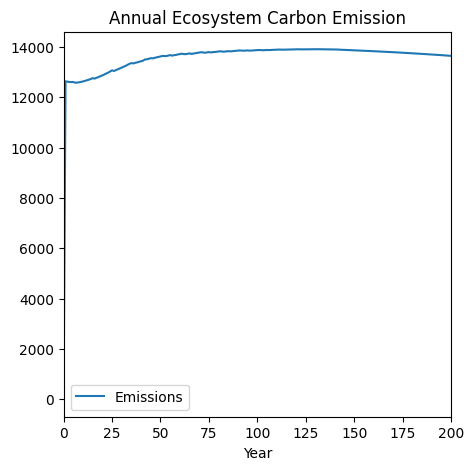

In [23]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

## Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [24]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [25]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,False,85,15.182275,0,0,fire,fire
1,tsa24_clipped,0,2401000,100,2401000,softwood,False,95,20.653789,0,0,fire,fire
2,tsa24_clipped,0,2401000,100,2401000,softwood,False,105,1.109374,0,0,fire,fire
3,tsa24_clipped,0,2401000,100,2401000,softwood,False,125,25.731748,0,0,fire,fire
4,tsa24_clipped,0,2401000,100,2401000,softwood,False,135,62.023828,0,0,fire,fire
5,tsa24_clipped,0,2401000,100,2401000,softwood,False,145,45.322290,0,0,fire,fire
6,tsa24_clipped,0,2401000,100,2401000,softwood,False,155,3.052804,0,0,fire,fire
7,tsa24_clipped,0,2402005,1201,2402005,hardwood,False,85,1.812979,0,0,fire,fire
8,tsa24_clipped,1,2401002,204,2401002,softwood,False,78,103.767403,0,0,fire,fire
9,tsa24_clipped,1,2401002,204,2401002,softwood,False,80,4.173147,0,0,fire,fire


In [26]:
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [27]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,False,0,1.0,0,0,fire,fire
1,tsa24_clipped,0,2402005,1201,2402005,hardwood,False,0,1.0,0,0,fire,fire
2,tsa24_clipped,1,2401002,204,2401002,softwood,False,0,1.0,0,0,fire,fire
3,tsa24_clipped,1,2401002,204,2421002,softwood,False,0,1.0,0,0,fire,harvest
4,tsa24_clipped,1,2402000,100,2402000,softwood,False,0,1.0,0,0,fire,fire
5,tsa24_clipped,1,2402002,204,2402002,softwood,False,0,1.0,0,0,fire,fire
6,tsa24_clipped,1,2403000,100,2403000,softwood,False,0,1.0,0,0,fire,fire
7,tsa24_clipped,1,2403002,204,2403002,softwood,False,0,1.0,0,0,fire,fire
8,tsa24_clipped,1,2403002,204,2423002,softwood,False,0,1.0,0,0,fire,harvest


In [28]:
df_sub = df.loc[(df['theme1'] == 1) & (df['last_pass_disturbance'] == 'fire')]
df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')

/tmp/ipykernel_20926/1329267401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
/tmp/ipykernel_20926/1329267401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')


In [29]:
df_sub

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
2,tsa24_clipped,1,2401002,204,2421002,softwood,False,0,1.0,0,0,fire,harvest
4,tsa24_clipped,1,2402000,100,2422000,softwood,False,0,1.0,0,0,fire,harvest
5,tsa24_clipped,1,2402002,204,2422002,softwood,False,0,1.0,0,0,fire,harvest
6,tsa24_clipped,1,2403000,100,2423000,softwood,False,0,1.0,0,0,fire,harvest
7,tsa24_clipped,1,2403002,204,2423002,softwood,False,0,1.0,0,0,fire,harvest


In [30]:
df = pd.concat([df, df_sub], ignore_index=True)

In [31]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,False,0,1.0,0,0,fire,fire
1,tsa24_clipped,0,2402005,1201,2402005,hardwood,False,0,1.0,0,0,fire,fire
2,tsa24_clipped,1,2401002,204,2401002,softwood,False,0,1.0,0,0,fire,fire
3,tsa24_clipped,1,2401002,204,2421002,softwood,False,0,1.0,0,0,fire,harvest
4,tsa24_clipped,1,2402000,100,2402000,softwood,False,0,1.0,0,0,fire,fire
5,tsa24_clipped,1,2402002,204,2402002,softwood,False,0,1.0,0,0,fire,fire
6,tsa24_clipped,1,2403000,100,2403000,softwood,False,0,1.0,0,0,fire,fire
7,tsa24_clipped,1,2403002,204,2403002,softwood,False,0,1.0,0,0,fire,fire
8,tsa24_clipped,1,2403002,204,2423002,softwood,False,0,1.0,0,0,fire,harvest
9,tsa24_clipped,1,2401002,204,2421002,softwood,False,0,1.0,0,0,fire,harvest


In [32]:
sit_tables['sit_inventory'] = df

In [33]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [34]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [35]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,1.0,0.000000,...,74.016010,52.671391,23.112688,0.000000,0.000000,5878.431742,6.068142,54.611643,0.0,0.000000
1,2,0,tsa24_clipped,0,2402005,1201,2402005,hardwood,1.0,0.000000,...,140.991892,0.000000,0.000000,120.560643,26.223323,12094.940302,10.912393,98.209112,0.0,0.000000
2,3,0,tsa24_clipped,1,2401002,204,2401002,softwood,1.0,0.000000,...,70.577311,38.209170,20.940326,0.000000,0.000000,5549.131806,5.574412,50.168153,0.0,0.000000
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,1.0,0.000000,...,56.591833,0.000000,0.000000,0.000000,0.000000,4504.469208,4.878363,43.903950,0.0,34.110922
4,5,0,tsa24_clipped,1,2402000,100,2402000,softwood,1.0,0.000000,...,78.415619,47.913734,22.404296,0.000000,0.000000,6182.050833,6.060943,54.546827,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,10,200,tsa24_clipped,1,2401002,204,2421002,softwood,1.0,45.198700,...,65.998607,4.506710,1.720728,0.000000,0.000000,4986.084611,4.878363,43.903950,0.0,34.110922
2810,11,200,tsa24_clipped,1,2402000,100,2422000,softwood,1.0,67.253021,...,75.835022,6.591921,1.969140,0.000000,0.000000,5815.777596,5.599995,50.398516,0.0,48.597173
2811,12,200,tsa24_clipped,1,2402002,204,2422002,softwood,1.0,65.652963,...,84.479828,6.777686,1.961866,0.000000,0.000000,6543.860481,6.063782,54.572506,0.0,53.757580
2812,13,200,tsa24_clipped,1,2403000,100,2423000,softwood,1.0,89.247889,...,95.235629,8.973548,2.220461,0.000000,0.000000,7437.034124,6.779255,61.011651,0.0,68.419040


In [36]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,DisturbanceCO2Production,DisturbanceCH4Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa24_clipped,0,2402005,1201,2402005,hardwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa24_clipped,1,2401002,204,2401002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa24_clipped,1,2402000,100,2402000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,10,200,tsa24_clipped,1,2401002,204,2421002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2810,11,200,tsa24_clipped,1,2402000,100,2422000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2811,12,200,tsa24_clipped,1,2402002,204,2422002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2812,13,200,tsa24_clipped,1,2403000,100,2423000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [38]:
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

Create Summany Carbon Indicators Curves

In [39]:
# Sum carbon pools
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

# Sum carbon fluxes
c_curves_f['all_fluxes'] = c_curves_f[all_fluxes].sum(axis=1)

In [40]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                           timestep                                   
tsa24_clipped 0 2401000 100 2401000 0              0.000000         0.000000   
                                    1              0.000100         0.142072   
                                    2              0.000803         0.399931   
                                    3              0.002724         0.575965   
                                    4              0.006477         0.742157   
...                                                     ...              ...   
tsa24_clipped 1 2403002 204 2423002 196          188.065886        17.376395   
                                    197          187.988917        17.373295   
                                    198          187.911944        17.370193   
                                    199          187.834968        17.367091   
                                    200          187.757989        17.363988   

                                              SoftwoodOther  \
dtype_key                           timestep                  
tsa24_clipped 0 2401000 100 2401000 0              0.000000   
                                    1              0.000000   
                                    2              0.009712   
                                    3              0.182878   
                                    4              0.430046   
...                                                     ...   
tsa24_clipped 1 2403002 204 2423002 196           64.901448   
                                    197           64.889178   
                                    198           64.876907   
                                    199           64.864635   
                                    200           64.852363   

                                              SoftwoodCoarseRoots  \
dtype_key                           timestep                        
tsa24_clipped 0 2401000 100 2401000 0                    0.000000   
                                    1                    0.018159   
                                    2                    0.052654   
                                    3                    0.098251   
                                    4                    0.153070   
...                                                           ...   
tsa24_clipped 1 2403002 204 2423002 196                 55.122518   
                                    197                 55.102983   
                                    198                 55.083447   
                                    199                 55.063909   
                                    200                 55.044370   

                                              SoftwoodFineRoots  \
dtype_key                           timestep                      
tsa24_clipped 0 2401000 100 2401000 0                  0.000000   
                                    1                  0.013403   
                                    2                  0.038465   
                                    3                  0.070817   
                                    4                  0.108597   
...                                                         ...   
tsa24_clipped 1 2403002 204 2423002 196                4.893790   
                                    197                4.892825   
                                    198                4.891861   
                                    199                4.890897   
                                    200                4.889933   

                                              HardwoodMerch  HardwoodFoliage  \
dtype_key                           timestep                                   
tsa24_clipped 0 2401000 100 2401000 0                   0.0              0.0   
                                    1                   0.0              0.0   
                                    2                   0.0              0.0   
               

In [41]:
# c_curves_p.to_csv('data/c_curves/curves_pools.csv', index=False)

In [42]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                           timestep                             
tsa24_clipped 0 2401000 100 2401000 0                              0.0   
                                    1                              0.0   
                                    2                              0.0   
                                    3                              0.0   
                                    4                              0.0   
...                                                                ...   
tsa24_clipped 1 2403002 204 2423002 196                            0.0   
                                    197                            0.0   
                                    198                            0.0   
                                    199                            0.0   
                                    200                            0.0   

                                              DisturbanceCH4Production  \
dtype_key                           timestep                             
tsa24_clipped 0 2401000 100 2401000 0                              0.0   
                                    1                              0.0   
                                    2                              0.0   
                                    3                              0.0   
                                    4                              0.0   
...                                                                ...   
tsa24_clipped 1 2403002 204 2423002 196                            0.0   
                                    197                            0.0   
                                    198                            0.0   
                                    199                            0.0   
                                    200                            0.0   

                                              DisturbanceCOProduction  \
dtype_key                           timestep                            
tsa24_clipped 0 2401000 100 2401000 0                             0.0   
                                    1                             0.0   
                                    2                             0.0   
                                    3                             0.0   
                                    4                             0.0   
...                                                               ...   
tsa24_clipped 1 2403002 204 2423002 196                           0.0   
                                    197                           0.0   
                                    198                           0.0   
                                    199                           0.0   
                                    200                           0.0   

                                              DisturbanceBioCO2Emission  \
dtype_key                           timestep                              
tsa24_clipped 0 2401000 100 2401000 0                               0.0   
                                    1                               0.0   
                                    2                               0.0   
                                    3                               0.0   
                                    4                               0.0   
...                                                                 ...   
tsa24_clipped 1 2403002 204 2423002 196                             0.0   
                                    197                             0.0   
                                    198                             0.0   
                                    199                             0.0   
                                    200                             0.0   

                                              DisturbanceBioCH4Emission  \
dtype_key                           timestep                              
tsa24_clipped 0 2401000 100 2401000 0       

In [43]:
# c_curves_f.to_csv('data/c_curves/curves_fluxes.csv', index=False)

In [44]:
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=pools+sum_pools, fluxes=fluxes+sum_fluxes)

found match for development key ('tsa24_clipped', '0', '2401000', '100', '2401000')
found match for development key ('tsa24_clipped', '0', '2401000', '100', '2401000')
found match for development key ('tsa24_clipped', '0', '2402005', '1201', '2402005')
found match for development key ('tsa24_clipped', '0', '2402005', '1201', '2402005')
found match for development key ('tsa24_clipped', '1', '2401002', '204', '2401002')
found match for development key ('tsa24_clipped', '1', '2401002', '204', '2421002')
found match for development key ('tsa24_clipped', '1', '2402000', '100', '2402000')
found match for development key ('tsa24_clipped', '1', '2402002', '204', '2402002')
found match for development key ('tsa24_clipped', '1', '2403000', '100', '2403000')
found match for development key ('tsa24_clipped', '1', '2403002', '204', '2403002')
found match for development key ('tsa24_clipped', '1', '2403002', '204', '2423002')


Get back the orginial inventory table

In [45]:
sit_inventory = pd.read_csv('data/libcbm_model_files/sit_inventory.csv')

In [46]:
sit_tables['sit_inventory'] = sit_inventory

In [47]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total net Emission (tons)'}>],
       dtype=object))

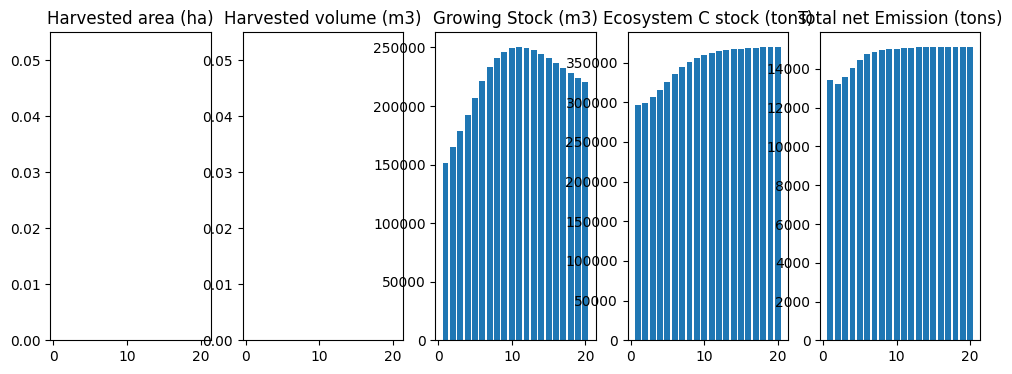

In [48]:
df = compile_scenario(fm)
plot_scenario(df)

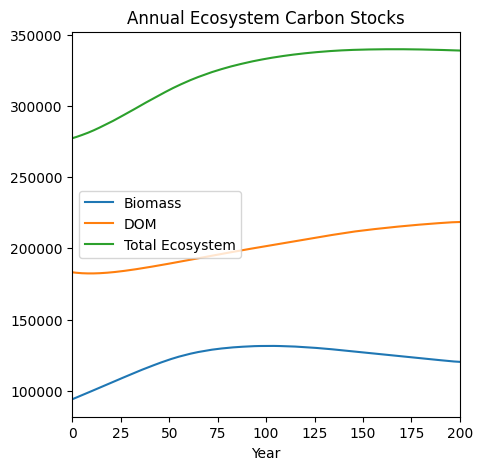

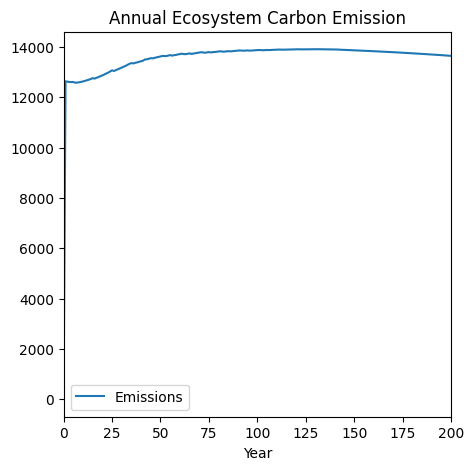

In [49]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period   biomass_pool       dom_pool       eco_pool          flux
 0        1   93948.941430  207146.156050  301095.097481  13423.787657
 1        2  100208.828775  203705.181025  303914.009800  13199.891702
 2        3  107281.434180  203083.390181  310364.824361  13542.194907
 3        4  115050.968754  204063.792992  319114.761746  14053.969422
 4        5  123005.876820  205880.942890  328886.819710  14463.818382
 5        6  130424.953698  207916.723888  338341.677586  14754.821196
 6        7  136319.309653  210025.541172  346344.850826  14885.778640
 7        8  140444.913203  212096.765906  352541.679109  14969.940660
 8        9  143162.150514  213948.589562  357110.740076  15020.393984
 9       10  144907.852602  215532.185085  360440.037687  15058.853933
 10      11  146057.993329  216919.556914  362977.550243  15092.399157
 11      12  146647.035417  218098.282610  364745.318027  15121.280862
 12      13  147002.299895  218872.077495  365874.377390  15142.365294
 13   

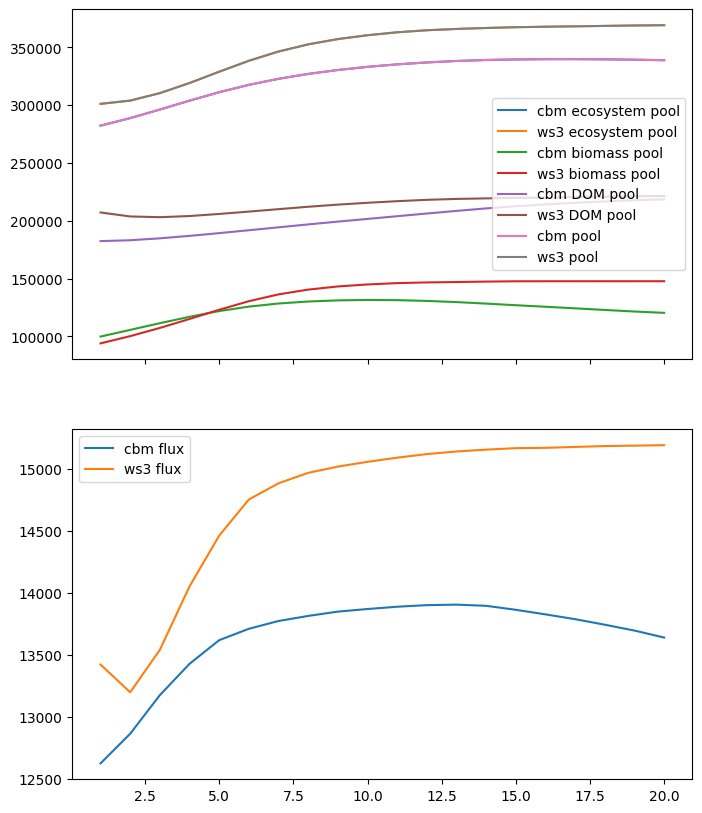

In [50]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

Looks good when there is no harvest!

Simulate some harvesting in all periods

In [51]:
fm.reset()
from util import schedule_harvest_areacontrol, compile_scenario, plot_scenario
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total net Emission (tons)'}>],
       dtype=object))

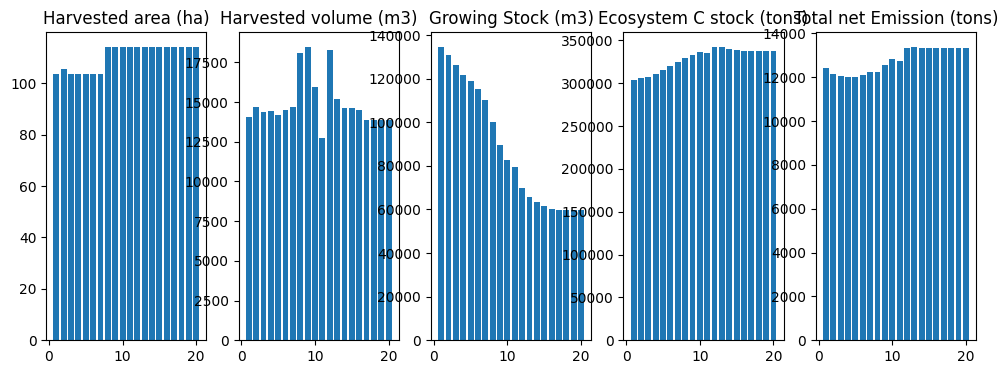

In [52]:
df = compile_scenario(fm)
plot_scenario(df)

In [53]:
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [54]:
from util import complie_events

In [55]:
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [56]:
sit_tables['sit_events'] = sit_events

In [57]:
sit_events = sit_events.drop_duplicates(ignore_index=True)

In [58]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24_clipped,1,2402002,204,2402002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,3.195379,harvest,10
1,tsa24_clipped,1,2402002,204,2402002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,10.057453,harvest,10
2,tsa24_clipped,1,2402000,100,2402000,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,0.058533,harvest,10
3,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,34.326292,harvest,10
4,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,9.591469,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,8.766114,harvest,200
158,tsa24_clipped,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,9.366845,harvest,200
159,tsa24_clipped,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.265359,harvest,200
160,tsa24_clipped,1,2403000,100,2423000,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.497807,harvest,200


In [59]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

(    period  biomass_pool       dom_pool       eco_pool          flux
 0        1  85340.218029  222053.940857  307394.158886  12436.054903
 1        2  82680.493934  226902.796695  309583.290629  12124.706665
 2        3  81190.510366  230270.662044  311461.172409  12033.190397
 3        4  81013.396843  233831.649225  314845.046069  11990.189053
 4        5  81906.814774  237611.570119  319518.384892  11973.128275
 5        6  83183.327029  241419.307915  324602.634944  12040.958798
 6        7  84418.444176  245474.176279  329892.620455  12189.526426
 7        8  82585.283613  251930.828379  334516.111992  12218.128105
 8        9  80788.882506  257299.358029  338088.240535  12537.646413
 9       10  80339.970736  262287.480327  342627.451063  12817.841978
 10      11  78398.816547  262833.972348  341232.788895  12733.296920
 11      12  79308.279441  269249.374189  348557.653630  13314.849043
 12      13  78041.893612  270055.604798  348097.498410  13385.031787
 13      14  76651.3

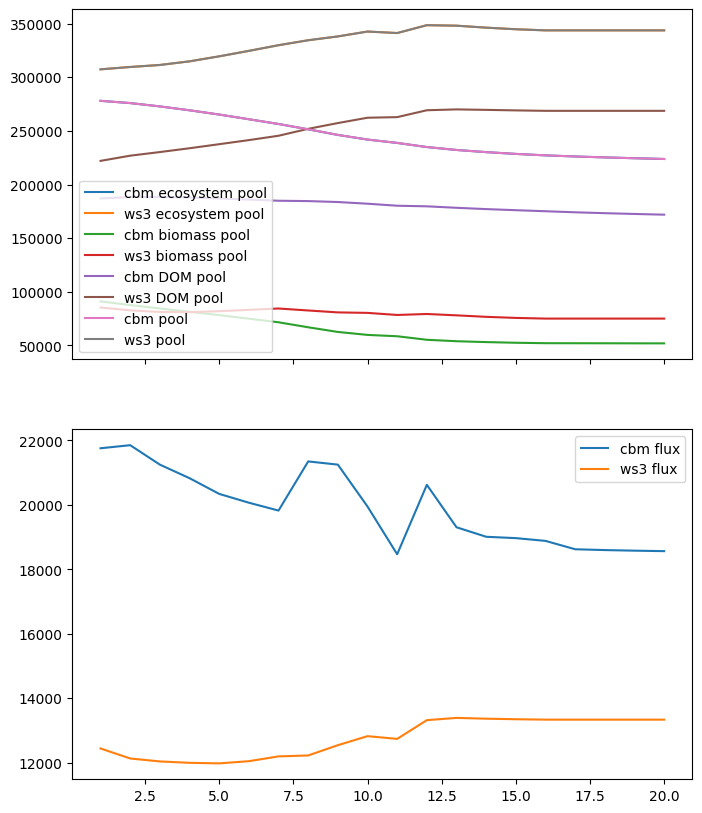

In [60]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

## Implement optimization-based action scheduling

In [61]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [62]:
import gurobipy as grb

Import functions

In [63]:
from util import cmp_c_z,cmp_c_cflw,cmp_c_caa,cmp_c_ci, gen_scenario 

Add a "null" action to the model for the optimization functions to work correctly.

In [64]:
fm.add_null_action()

Define base and other scenarios below

In [65]:
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    cgen_cp = {}
    cgen_cf = {}
    
    # define harvest area and harvest volume flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    in_cp = 1319073591.63 #initial total ecosystem carbon stock
    in_cf = 20034534.75 #intial total ecosystem carbon emission
    AAC = 7031963. # AAC of TSA24

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        cgen_gs = {'lb':{1:0}, 'ub':{1:9999999999}} 
        cgen_hv = {'lb':{1:0}, 'ub':{1:9999999999}}    
    elif scenario_name == 'base_h': 
        # Base scenario
        print('running base scenario')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{1:AAC}}
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with carbon constraints')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{1:AAC}}   
        cgen_cp = {'lb':{10:in_cp*0.9}, 'ub':{10:in_cp*0.9+1}} #Not less than 90% of initial total ecosystem carbon stock
        cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}
    elif scenario_name == 'increase_50%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 50% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.5-1}, 'ub':{1:AAC*1.5}}
    elif scenario_name == 'increase_100%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 100% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}
    elif scenario_name == 'increase_500%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 500% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*2-1}, 'ub':{1:AAC*2}}
    elif scenario_name == 'increase_1000%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 1000% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*10-1}, 'ub':{1:AAC*10}}
    elif scenario_name == 'increase_5000%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 5000% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*50-1}, 'ub':{1:AAC*50}}
    elif scenario_name == 'increase_10000%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 10000% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*100-1}, 'ub':{1:AAC*100}}    
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,
                     cgen_cp=cgen_cp,
                     cgen_cf=cgen_cf)

    fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

running base scenario
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('tsa24_clipped', '1', '2402000', '100', '2422000')
dtk: ('ts

(<Figure size 1200x400 with 5 Axes>,
     period        oha          ohv            ogs            ocp           ocf
 0        1  54.746141  6630.934011  143292.285755  303269.689239  12904.959215
 1        2  57.483448  6299.387311  149699.069674  309520.809244  12735.408341
 2        3  57.483448  6299.387311  154488.828996  316537.155535  12938.427318
 3        4  57.483448  6307.100130  159568.894841  324941.934817  13201.605265
 4        5  57.483448  6889.391270  165131.063050  333938.165303  13429.896844
 5        6  57.121017  6962.480712  169720.859205  343150.828575  13684.657267
 6        7  53.017177  6962.480712  171916.379107  351167.727192  13949.224797
 7        8  52.008834  6962.480712  171988.640273  358904.481929  14278.594466
 8        9  52.008834  6962.480712  170888.581676  366456.103390  14642.806044
 9       10  52.008834  6962.480712  169281.773655  374279.347832  15072.907703
 10      11  52.008834  6962.480712  167722.677603  382681.628760  15558.659634
 11

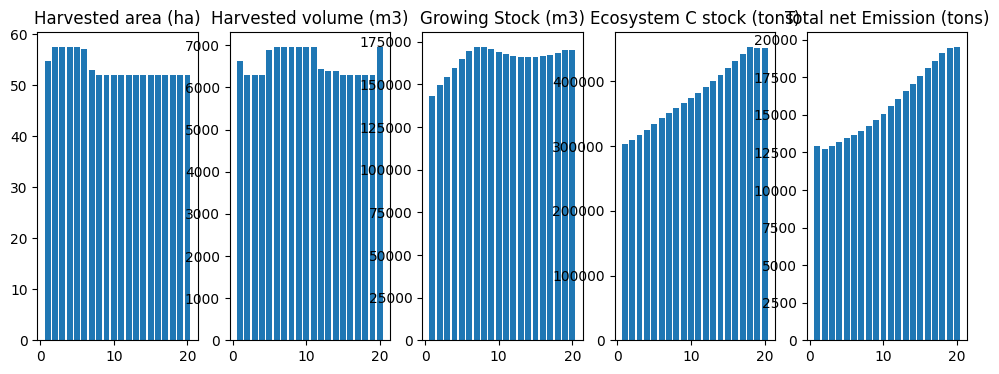

In [66]:
run_scenario(fm,'base') # Maximize Carbon Stock

There some development types without carbon yield curves. So plug the C curves into them again.

In [67]:
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=pools+sum_pools, fluxes=fluxes+sum_fluxes)

found match for development key ('tsa24_clipped', '0', '2401000', '100', '2401000')
found match for development key ('tsa24_clipped', '0', '2401000', '100', '2401000')
found match for development key ('tsa24_clipped', '0', '2402005', '1201', '2402005')
found match for development key ('tsa24_clipped', '0', '2402005', '1201', '2402005')
found match for development key ('tsa24_clipped', '1', '2401002', '204', '2401002')
found match for development key ('tsa24_clipped', '1', '2401002', '204', '2421002')
found match for development key ('tsa24_clipped', '1', '2402000', '100', '2402000')
found match for development key ('tsa24_clipped', '1', '2402002', '204', '2402002')
found match for development key ('tsa24_clipped', '1', '2403000', '100', '2403000')
found match for development key ('tsa24_clipped', '1', '2403002', '204', '2403002')
found match for development key ('tsa24_clipped', '1', '2403002', '204', '2423002')
found match for development key ('tsa24_clipped', '1', '2402002', '204', '

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 116 rows, 2526 columns and 56250 nonzeros
Model fingerprint: 0x15fd9489
Coefficient statistics:
  Matrix range     [3e-02, 4e+04]
  Objective range  [1e+03, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 16 rows and 8 columns
Presolve time: 0.03s
Presolved: 100 rows, 2518 columns, 49710 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.602e+03
 Factor NZ  : 5.050e+03 (roughly 1 MB of memory)
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 Thread

(<Figure size 1200x400 with 5 Axes>,
     period        oha          ohv            ogs            ocp           ocf
 0        1  57.756501  7033.558742  142818.609601  303615.533883  12876.562997
 1        2  60.644326  6681.880805  148764.752359  309996.823770  12709.315566
 2        3  60.644326  6681.880805  153078.143205  317020.743227  12902.542507
 3        4  60.644326  6681.880805  157679.123297  325387.506631  13153.662911
 4        5  60.644326  7181.842268  162844.829752  334383.587793  13373.300898
 5        6  60.589357  7385.236679  166864.871498  343600.364907  13622.716243
 6        7  56.236335  7385.236679  168498.217188  351594.645792  13894.048849
 7        8  54.868676  7385.236679  168070.096504  359319.793103  14238.432631
 8        9  54.868676  7385.236679  166589.627883  367034.156084  14619.145544
 9       10  54.868676  7385.236679  164675.051830  375100.525929  15071.378192
 10      11  54.868676  7385.236679  162881.896201  383815.548591  15583.419273
 11

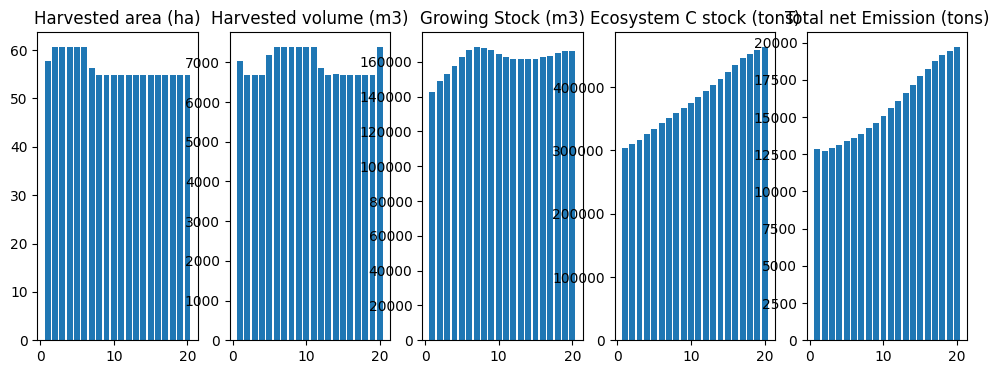

In [68]:
run_scenario(fm,'base') # Maximize Carbon Stock

In [69]:
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [70]:
sit_tables['sit_events'] = sit_events

In [71]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

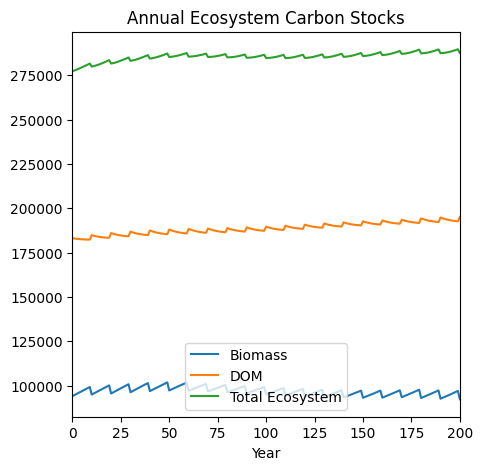

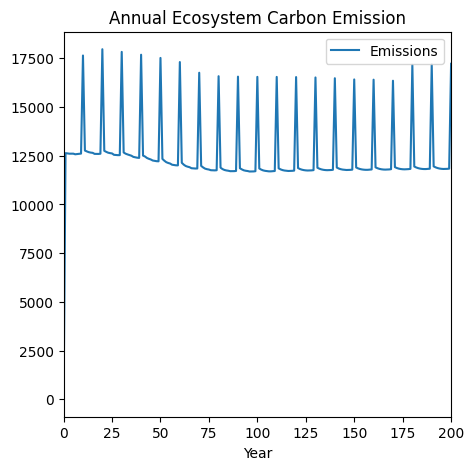

In [72]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period   biomass_pool       dom_pool       eco_pool          flux
 0        1   89455.637618  218492.083652  307947.721270  12887.535885
 1        2   91260.685388  222691.922485  313952.607873  12709.664709
 2        3   93879.810562  226875.625445  320755.436008  12880.549470
 3        4   97556.252633  231574.506586  329130.759219  13136.985440
 4        5  101674.648434  236501.128233  338175.776667  13359.148975
 5        6  105866.772171  241472.780220  347339.552391  13598.143031
 6        7  109714.342436  245679.570412  355393.912848  13872.949509
 7        8  113083.691847  250129.594963  363213.286810  14219.438538
 8        9  116273.037587  254893.005741  371166.043328  14618.513786
 9       10  119602.366971  259871.395972  379473.762944  15087.364363
 10      11  123387.131266  265036.810758  388423.942024  15601.856350
 11      12  127448.492384  270314.238821  397762.731206  16127.649705
 12      13  131895.752948  275725.807105  407621.560052  16665.196504
 13   

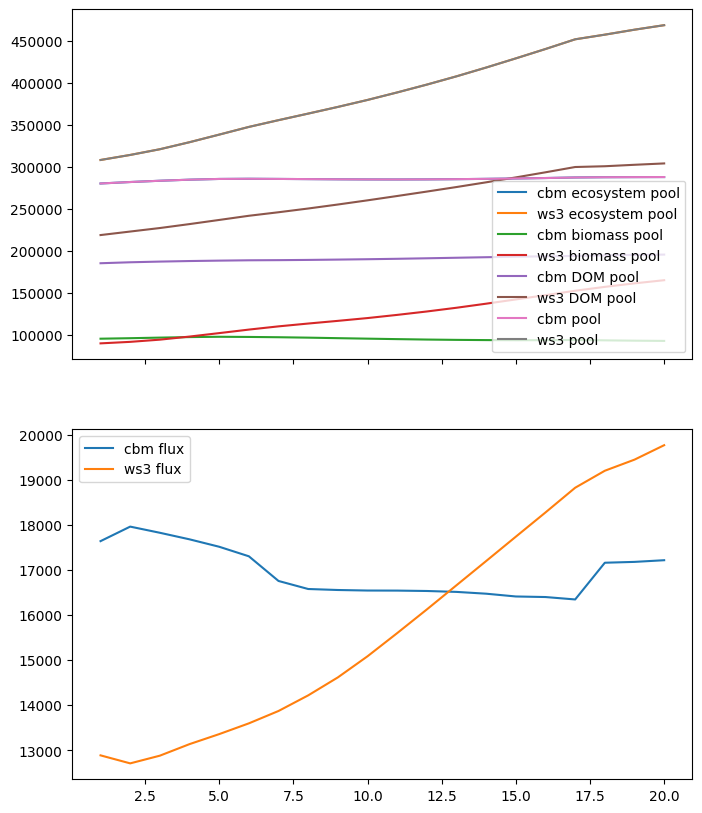

In [73]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [74]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  1.8  minutes to run this script.


In [75]:
# run_scenario(fm,'base_h') # Maximize Carbon Stock with Havest Volume & Area Constraints

In [76]:
# run_scenario(fm,'base_h') # Maximize Carbon Stock with Havest Volume & Area Constraints with Havest Volume & Area Constraints

In [77]:
# run_scenario(fm,'base_c') # Maximize Carbon Stocks with Havest Volume & Area Constraints and Carbon Pools & Fluxes Constraints

In [78]:
#run_scenario(fm,'base') # Maximize Havest Volume without Havest Volume & Area Constraints

In [79]:
#run_scenario(fm,'base_h') # Maximize Havest Volume with Havest Volume & Area Constraints

In [80]:
#run_scenario(fm,'base_c') # Maximize Havest Volume with Havest Volume & Area Constraints and Carbon Pools & Fluxes Constraints

In [81]:
#run_scenario(fm,'reduce_10%_AAC')

In [82]:
#run_scenario(fm,'reduce_20%_AAC')

In [83]:
#run_scenario(fm,'increase_20%_AAC')

In [84]:
#run_scenario(fm,'increase_20%_AAC')